# IoU tests 

Plain notebook (NB) to play with the different type of IoU (Intersection over Union) algorithms used in machine learning. 

This NB is talking about IoU, DIoU, GIoU... 

Links to the papers are also given. 




In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
# Import patches
from matplotlib import patches
from matplotlib.patches import Rectangle
from numba import jit
from numba.typed import List


## Define 3 basic boxes to play 

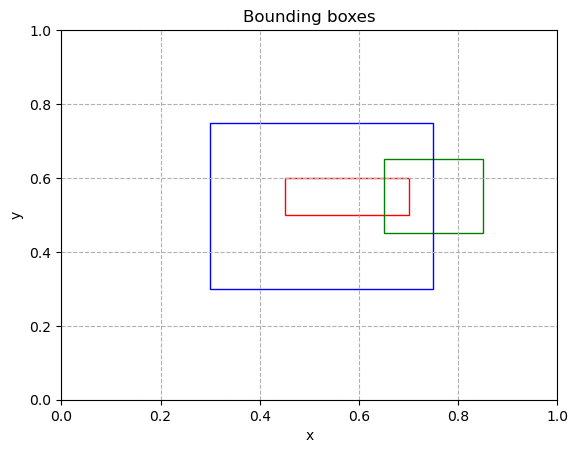

In [3]:
# Define 3 examples of bounding boxes
box_1 = [0.45, 0.5, 0.25, 0.1]
typed_box_1 = List()  # Trick to avoid "reflection list" warning
[typed_box_1.append(float(i)) for i in box_1]
box_1 = typed_box_1

box_2 = [0.65, 0.45, 0.2, 0.2]
typed_box_2 = List()
[typed_box_2.append(float(i)) for i in box_2]
box_2 = typed_box_2

box_3 = [0.3, 0.3, 0.45, 0.45]
typed_box_3 = List()
[typed_box_3.append(float(i)) for i in box_3]
box_3 = typed_box_3

# Plot bounding boxes
fig = plt.figure()
ax = fig.add_subplot(111)

ax.add_patch(patches.Rectangle((box_1[0], box_1[1]), box_1[2], box_1[3],
    fill=False, color='red'))
ax.add_patch(patches.Rectangle((box_2[0], box_2[1]), box_2[2], box_2[3],
    fill=False, color='green'))
ax.add_patch(patches.Rectangle((box_3[0], box_3[1]), box_3[2], box_3[3],
    fill=False, color='blue'))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Bounding boxes')
plt.grid(True, linestyle='--')
plt.show()


## Define IoU, GIoU and DIoU

### IoU


"IoU , also known as Jaccard index, is the most commonly
used metric for comparing the similarity between two arbi-
trary shapes. IoU encodes the shape properties of the ob-
jects under comparison, e.g. the widths, heights and loca-
tions of two bounding boxes, into the region property and
then calculates a normalized measure that focuses on their
areas (or volumes). This property makes IoU invariant to
the scale of the problem under consideration."


<img src="./images/IoU_notebook/img_IoU.png" >

In [4]:
@jit(nopython=True, cache=True, fastmath=False)
def fct_IoU(box1, box2):
    """
    Compute IoU between two bounding boxes
    (from Everingham et al. 2010, 
            see https://link.springer.com/article/10.1007/s11263-009-0275-4)
    Formulae : IoU = Area of intersection / Area of union
        where area of union = area of box1 + area of box2 - area of intersection
        and   area of intersection = max(0, xB-xA)*max(0, yB-yA)

    INPUT:
    ---------
    box1: list of 4 elements [x1, y1, w1, h1]
    box2: list of 4 elements [x2, y2, w2, h2]

    OUTPUT:
    ---------
    Return IoU
    """
    # Min and max coordinates of the intersection rectangle 
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[0]+box1[2], box2[0]+box2[2])
    yB = min(box1[1]+box1[3], box2[1]+box2[3])

    interArea = max(0, xB-xA)*max(0, yB-yA)

    # Compute area of both boxes
    box1Area = box1[2]*box1[3]
    box2Area = box2[2]*box2[3]

    # Compute IoU
    return float(interArea)/float(box1Area+box2Area-interArea)

### Generalized IoU

From the paper Rezatofighi et al. 2019 (see https://arxiv.org/pdf/1902.09630.pdf)

Since IoU does not reflect if two shapes are in vicinity of each other or very far from each other author introduced a convex shape C which is the smallest shape that encloses the two shapes

<img src="./images/IoU_notebook/img_GIoU.png" >

$$GIoU = IoU - \frac{\mid C \setminus (A\cup B) \mid}{C}$$

In [5]:
@jit(nopython=True, cache=True, fastmath=False)
def fct_GIoU(box1, box2):
    """
    Compute Generalized IoU (GIoU) between two bounding boxes
    (from Rezatofighi et al. 2019, see https://arxiv.org/pdf/1902.09630.pdf)
    
    Formulae : GIoU = IoU - (C - Union)/C
        where   C = smallest convex set that contains both boxes,
              IoU = Area of intersection / Area of union
        and Union = area of C - area of intersection
    
    INPUT:
    ---------
    box1: list of 4 elements [x1, y1, w1, h1]
    box2: list of 4 elements [x2, y2, w2, h2]

    OUTPUT:
    ---------
    Return GIoU
        
    """
    # Min and max coordinates of the intersection rectangle 
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[0]+box1[2], box2[0]+box2[2])
    yB = min(box1[1]+box1[3], box2[1]+box2[3])

    interArea = max(0, xB-xA)*max(0, yB-yA)

    # Compute area of both boxes
    box1Area = box1[2]*box1[3]
    box2Area = box2[2]*box2[3]

    # Compute IoU
    iou = float(interArea)/float(box1Area+box2Area-interArea)

    # Compute area of the smallest convex set that contains both boxes
    C = (max(box1[0]+box1[2], box2[0]+box2[2])-min(box1[0], box2[0])) * \
        (max(box1[1]+box1[3], box2[1]+box2[3])-min(box1[1], box2[1]))

    # Compute GIoU
    return iou - (C - (box1Area+box2Area-interArea))/C

### Distance IoU (D-IoU)

From Zheng et al. 2020, see https://arxiv.org/pdf/1911.08287.pdf

The Distance-IoU (DIoU) loss for bounding box regression simply add
a penalty term on IoU loss to directly minimize the normalized distance between central points of two bounding boxes, leading to much faster convergence than GIoU loss.

<img src="./images/IoU_notebook/img_DIoU.png" >


$$DIoU = IoU - \frac{d^2}{c^2} $$

where $d^2$ distance of the diagonal of the smallest enclosing box and $c^2$ is the distance between the center of the two boxes.

In [6]:
@jit(nopython=True, cache=True, fastmath=False)
def fct_DIoU(box1, box2):
    """ 
    Compute Distance IoU (DIoU) between two bounding boxes
    (from Zheng et al. 2020, see https://arxiv.org/pdf/1911.08287.pdf)

    Formulae : DIoU = IoU - d^2/c^2
        where   d = distance between center of boxes,
                c = diagonal of the smallest convex set that contains both boxes,
              IoU = Area of intersection / Area of union
    
    INPUT:
    ---------
    box1: list of 4 elements [x1, y1, w1, h1]
    box2: list of 4 elements [x2, y2, w2, h2]

    OUTPUT:
    ---------
              
    """
    # Min and max coordinates of the intersection rectangle 
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[0]+box1[2], box2[0]+box2[2])
    yB = min(box1[1]+box1[3], box2[1]+box2[3])

    interArea = max(0, xB-xA)*max(0, yB-yA)

    # Compute area of both boxes
    box1Area = box1[2]*box1[3]
    box2Area = box2[2]*box2[3]

    # Compute IoU
    iou = float(interArea)/float(box1Area+box2Area-interArea)

    # Compute distance between center of boxes
    center_box1 = [box1[0]+box1[2]/2, box1[1]+box1[3]/2]
    center_box2 = [box2[0]+box2[2]/2, box2[1]+box2[3]/2]
    d = np.sqrt((center_box1[0]-center_box2[0])**2 + (center_box1[1]-center_box2[1])**2)

    # Compute diagonal of the smallest convex set that contains both boxes
    c = np.sqrt((max(box1[0]+box1[2], box2[0]+box2[2])-min(box1[0], box2[0]))**2 + \
        (max(box1[1]+box1[3], box2[1]+box2[3])-min(box1[1], box2[1]))**2)

    # Compute DIoU
    return iou - (d**2)/c**2


### Complete IoU

$$DIoU = IoU - \frac{d^2}{c^2} + \alpha v $$
where 
$$v = \frac{4}{\pi^2}({arctan\frac{w^{gt}}{h^{gt}}-arctan\frac{w}{h}})^2$$


The DIoU mains at considering simultaneously the overlap area and the central distance of  bounding boxes. However, the consistency of the aspect ratios for bounding boxes is also an important geometric factor. 

$v$ measures the consistancy of the aspect ratio.

In [7]:
@jit(nopython=True, cache=True, fastmath=False)
def fct_CIoU(box1, box2):
    """
    Compute Complete IoU (CIoU) between two bounding boxes
    
    Formulae : CIoU = IoU - d^2/c^2 - v
        where   d = distance between center of boxes,
                c = diagonal of the smallest convex set that contains both boxes,
                v = (4/pi^2) * arctan(w1/h1) - (4/pi^2) * arctan(w2/h2)
              IoU = Area of intersection / Area of union

    INPUT:
    ---------
    box1: list of 4 elements [x1, y1, w1, h1]
    box2: list of 4 elements [x2, y2, w2, h2]

    OUTPUT:
    ---------
    Return CIoU
    """
    # Min and max coordinates of the intersection rectangle 
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[0]+box1[2], box2[0]+box2[2])
    yB = min(box1[1]+box1[3], box2[1]+box2[3])

    interArea = max(0, xB-xA)*max(0, yB-yA)

    # Compute area of both boxes
    box1Area = box1[2]*box1[3]
    box2Area = box2[2]*box2[3]

    # Compute IoU
    iou = float(interArea)/float(box1Area+box2Area-interArea)

    # Compute distance between center of boxes
    center_box1 = [box1[0]+box1[2]/2, box1[1]+box1[3]/2]
    center_box2 = [box2[0]+box2[2]/2, box2[1]+box2[3]/2]
    d = np.sqrt((center_box1[0]-center_box2[0])**2 + (center_box1[1]-center_box2[1])**2)

    # Compute diagonal of the smallest convex set that contains both boxes
    c = np.sqrt((max(box1[0]+box1[2], box2[0]+box2[2])-min(box1[0], box2[0]))**2 + \
        (max(box1[1]+box1[3], box2[1]+box2[3])-min(box1[1], box2[1]))**2)

    # Compute v
    v = (4/np.pi**2) * np.arctan(box1[2]/box1[3]) - (4/np.pi**2) * np.arctan(box2[2]/box2[3])

    # Compute CIoU
    return iou - (d**2)/c**2 - v

In [8]:

# tests
iou_12 = fct_IoU(box_2, box_1)
iou_13 = fct_IoU(box_1, box_3)
iou_23 = fct_IoU(box_2, box_3)
# tests GIoU
giou_12 = fct_GIoU(box_2, box_1)
giou_13 = fct_GIoU(box_1, box_3)
giou_23 = fct_GIoU(box_2, box_3)
# tests DIoU
diou_12 = fct_DIoU(box_2, box_1)
diou_13 = fct_DIoU(box_1, box_3)
diou_23 = fct_DIoU(box_2, box_3)


print('IoU between box_1 and box_2: %.2f' % iou_12)
print('GIoU between box_1 and box_2: %.2f' % giou_12)
print('DIoU between box_1 and box_2: %.2f' % diou_12)
print('')
print('IoU between box_1 and box_3: %.2f' % iou_13)
print('GIoU between box_1 and box_3: %.2f' % giou_13)
print('DIoU between box_1 and box_3: %.2f' % diou_13)
print('')
print('IoU between box_2 and box_3: %.2f' % fct_IoU(box_2, box_3))
print('GIoU between box_2 and box_3: %.2f' % fct_GIoU(box_2, box_3))
print('DIoU between box_2 and box_3: %.2f' % fct_DIoU(box_2, box_3))


IoU between box_1 and box_2: 0.08
GIoU between box_1 and box_2: -0.17
DIoU between box_1 and box_2: -0.07

IoU between box_1 and box_3: 0.12
GIoU between box_1 and box_3: 0.12
DIoU between box_1 and box_3: 0.12

IoU between box_2 and box_3: 0.09
GIoU between box_2 and box_3: -0.01
DIoU between box_2 and box_3: -0.01


### Comparison between IoU, GIoU and DIoU

Simulation of a large quantity of boxes and computation of the different IoU

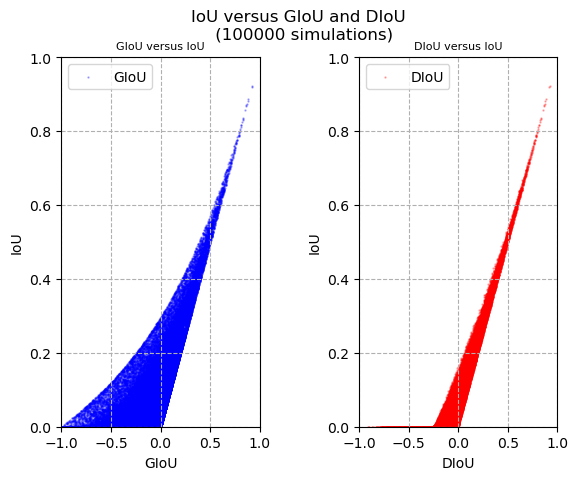

In [16]:
# Number of simulations
nb_sim = 100000

# Define list of IoU, GIoU and DIoU
list_iou = []
list_giou = []
list_diou = []

# Simulate boxes
for i in range(nb_sim):
    # Generate random boxes
    box_1 = np.random.rand(4)
    box_2 = np.random.rand(4)
    # Compute IoU, GIoU and DIoU
    list_iou.append(fct_IoU(box_1, box_2))
    list_giou.append(fct_GIoU(box_1, box_2))
    list_diou.append(fct_DIoU(box_1, box_2))

# Plot IoU vs GIoU in one subplot and IoU vs DIoU in another subplot
    
fig = plt.figure()
plt.suptitle(f"IoU versus GIoU and DIoU \n ({nb_sim} simulations)")
# Space between subplots
fig.subplots_adjust(wspace=0.5, hspace=0.5)

ax = fig.add_subplot(121)
ax.scatter(list_giou, list_iou, color='blue', label='GIoU', s=.5, alpha=0.3)
ax.set_xlim([-1, 1])
ax.set_ylim([0, 1]) 
ax.grid(True, linestyle='--')
ax.set_xlabel('GIoU')
ax.set_ylabel('IoU')
ax.set_title('GIoU versus IoU', fontsize=8)
ax.legend()

ax2 = fig.add_subplot(122)
ax2.scatter(list_diou, list_iou, color='red', label='DIoU', s=.5, alpha=0.3)
ax2.set_xlim([-1, 1])
ax2.set_ylim([0, 1])
ax2.grid(True, linestyle='--')
ax2.set_xlabel('DIoU')
ax2.set_ylabel('IoU')
ax2.set_title(f'DIoU versus IoU', fontsize=8)
ax2.legend()

plt.grid(True, linestyle='--')
plt.show()

## 3D version of the IoU

Just for the test, we can easely generalize the calculation of the different IoU

In [10]:
def fct_3D_GIoU(box1, box2):
    """
    Compute 3D GIoU between two bounding boxes
    (after Rezatofighi et al. 2019, see https://arxiv.org/pdf/1902.09630.pdf)
    Same a 2D GIoU but for 3D bounding boxes


    Formulae : 3DIoU = IoU - (C - Union)/C
        where   C = smallest convex set that contains both boxes,
              IoU = Area of intersection / Area of union
        and Union = area of C - area of intersection
    
    INPUT:
    ---------
    box1: list of 6 elements [x1, y1, z1, w1, h1, l1]
    box2: list of 6 elements [x2, y2, z2, w2, h2, l2]

    OUTPUT:
    ---------
    Return 3DIoU
        
    """
    # Min and max coordinates of the intersection rectangle 
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    zA = max(box1[2], box2[2])
    xB = min(box1[0]+box1[3], box2[0]+box2[3])
    yB = min(box1[1]+box1[4], box2[1]+box2[4])
    zB = min(box1[2]+box1[5], box2[2]+box2[5])

    interVol = max(0, xB-xA)*max(0, yB-yA)*max(0, zB-zA)

    # Compute area of both boxes
    box1Vol = box1[3]*box1[4]*box1[5]
    box2Vol = box2[3]*box2[4]*box2[5]

    # Compute IoU
    iou = float(interVol)/float(box1Vol+box2Vol-interVol)

    # Compute area of the smallest convex set that contains both boxes
    C = (max(box1[0]+box1[3], box2[0]+box2[3])-min(box1[0], box2[0])) * \
        (max(box1[1]+box1[4], box2[1]+box2[4])-min(box1[1], box2[1])) * \
        (max(box1[2]+box1[5], box2[2]+box2[5])-min(box1[2], box2[2]))
    
    # Compute 3D GIoU
    return iou - (C - (box1Vol+box2Vol-interVol))/C

# Define 3 examples of bounding boxes
box_1 = [0.45, 0.5, 0.25, 0.1, 0.2, 0.3]
typed_box_1 = List()  # Trick to avoid "reflection list" warning
[typed_box_1.append(float(i)) for i in box_1]
box_1 = typed_box_1

box_2 = [0.65, 0.45, 0.2, 0.2, 0.1, 0.1]
typed_box_2 = List()
[typed_box_2.append(float(i)) for i in box_2]
box_2 = typed_box_2

box_3 = [0.3, 0.3, 0.45, 0.45, 0.2, 0.2]
typed_box_3 = List()
[typed_box_3.append(float(i)) for i in box_3]
box_3 = typed_box_3

# tests 3D GIoU
giou_12 = fct_3D_GIoU(box_2, box_1)
giou_13 = fct_3D_GIoU(box_1, box_3)
giou_23 = fct_3D_GIoU(box_2, box_3)

print('3D GIoU between box_1 and box_2: %.2f' % giou_12)
print('3D GIoU between box_1 and box_3: %.2f' % giou_13)
print('3D GIoU between box_2 and box_3: %.2f' % giou_23)


3D GIoU between box_1 and box_2: -0.77
3D GIoU between box_1 and box_3: -0.67
3D GIoU between box_2 and box_3: -0.68
